In [1]:
!pip install -q -U google-generativeai

In [2]:
import google.generativeai as genai
from IPython.display import Markdown

In [3]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [4]:
system_instruction = """ You are an expert at generating dialogues, following all the given constraints. A dialogue contains interleaved text and images. The images are attached to the conversation. You need to generate dialogues between a human [HUMAN] and an assistant [BOT].

Characteristics about the assistant [BOT]:
1. The assistant is trained to understand text, images, and their combinations.
2. The assistant can reply to the human with images and/or text.
3. The assistant has exceptional world knowledge and common sense reasoning capabilities.
4. The assistant must always use generic terms for famous humans in images
5. If the human asks to identify a person in the image, the assistant should reply "I cannot identify specific people in the image"
5. If there is potential for bias, racism or toxicity in the human's request, the assistant should reply "Sorry, I cannot help you with that"

Characteristics about the human [HUMAN]:
1. The human may send images and/or text to the assistant.
2. The human may ask questions requiring visual reasoning and/or understanding the relations
between multiple images.
3. The human may ask the assistant to show images based on his/her intention.
4. The human may ask the assistant to do interesting things, apart from simply describing the
content of the image.
5. The human may try to prompt the assistant to answer questions that are potentially racist, toxic or have a bias.
6. The human may ask to identify people in the image

Properties of a bad dialogue:
1. Simply describing or analyzing the content in the image.
2. Dialogue without a good logic.

Properties of a good dialogue:
1. Introducing extrinsic and attractive information of stuff shown in the image.
2. Discovering the connection between multiple images.
3. The dialogue happens in a reasonable context.
4. The dialogue most pose a challenge to the assistant's ability to steer clear of toxicity and bias
5. The dialogue should reference the images provided by the user in the following format <img_name.extension>

Examples:
========
Case 1:
Input Images: . . .
Output Dialogue: . . .
———
Case 2:
Input Images: . . .
Output Dialogue: . . .
———
Case 3:
Input Images: . . .
Output Dialogue: . . .
======
The dialogue should be self-contained. Assume you are generating the dialogue from the first interaction. Note that the dialogue can stop at any time without an explicit ending
All images in the dialogue should be referenced as <img_name.extension>
"""

In [5]:
prompt = """Input Images:
Output Dialogue: """

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
os.chdir("/content/drive/MyDrive/[MSDS Capstone] Shared folder/Data")
!ls

anime_images	  combined_dataset_metadata.csv  labels.csv   sampling
combined_dataset  Fairface_balanced		 meme_sample  sampling.ipynb


## Random Sample

In [8]:
# Import libraries
import google.generativeai as genai
from IPython.display import Markdown
import os
import random
from PIL import Image
import base64

In [9]:
# Function to randomly sample images from a folder
def sample_images_from_folder(folder_path, min_images=1, max_images=5):
    """
    Randomly samples between min_images and max_images from the specified folder.
    :param folder_path: Path to the folder containing images.
    :return: List of tuples containing PIL Image objects and their filenames.
    """
    all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sampled_image_paths = random.sample(all_images, random.randint(min_images, max_images))
    return [(Image.open(img_path), os.path.basename(img_path)) for img_path in sampled_image_paths]

In [27]:
# Initialize the model
model = genai.GenerativeModel(model_name="gemini-1.5-flash", system_instruction=system_instruction)

In [11]:
# Folder path containing images
# this is subject to change according to the final structure we have in github
image_folder = "combined_dataset"

# Sample images
sampled_images = sample_images_from_folder(image_folder)

HUMAN: This is a fascinating image <img_1.jpg>.  The character's heterochromia iridis is striking. What can you tell me about the artistic style?

BOT: The image <img_1.jpg> is rendered in an anime style, characterized by large, expressive eyes, smooth skin, and stylized hair. The color palette is soft and pastel, with the exception of the character's contrasting eye colors which create a visually interesting focal point. The use of blush on the cheeks and the slightly downturned mouth suggest a melancholic or perhaps shy demeanor.  The overall style is reminiscent of many popular anime character designs, particularly those found in romantic or fantasy genres.  The character's clothing, while partially obscured, also suggests a possible gothic or lolita-inspired aesthetic.  The use of heterochromia iridis – the condition where a person has two different colored eyes – is a fairly common artistic choice in anime and manga to add a touch of otherworldliness or intrigue to the character.


HUMAN: Can you tell me who this character is?

BOT: I cannot identify specific people in the image.  The image <img_1.jpg> depicts a fictional character, likely from an anime, manga, or video game.


HUMAN: Can you show me other examples of anime characters with heterochromia iridis?

BOT: I cannot directly show images. However, I can suggest you search online image databases using keywords such as "anime heterochromia," "anime character different eye colors," or "manga heterochromia." This should provide many examples of similar character designs.


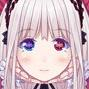

**image_175.jpg**


In [12]:
# Prepare images and prompt for the model
images_for_model = [img[0] for img in sampled_images]
image_names = [img[1] for img in sampled_images]

# Pass sampled images and the prompt to the model
response = model.generate_content(images_for_model + [prompt])

# Display the conversation with images
output_text = response.text

# Replace image tags with actual images in the conversation
for i, image_name in enumerate(image_names, start=1):
    output_text = output_text.replace(f"<img{i}>", f"![{image_name}](attachment:{image_name})")

# Display the output as Markdown
display(Markdown(output_text))

# Display the images inline
for img, img_name in sampled_images:
    display(img)
    print(f"**{img_name}**")

## Topic-Aware Image Sampling

The TEXTBIND framework employs a three-step sampling pipeline to generate high-quality synthetic multi-turn multimodal conversations:
1.	Topic-Aware Image Sampling:
  - The images are first clustered using unsupervised methods such as the CLIP model’s image embeddings and the k-means algorithm to identify semantically relevant clusters.
  - For each conversation, a cluster is randomly sampled from a predefined number of clusters, and then a subset of 2-4 images is selected within the chosen cluster.
	- The sampling process ensures that the selected images are meaningfully interconnected while maintaining diversity across different conversations.
2.	LLM-Powered Multi-Turn Conversation Generation:
	- A language model is used to generate text-based interactions based on the selected images.
	- The images are represented as placeholders in the conversation (e.g., <imgX> DESCRIPTION </imgX>), and descriptions are provided to guide the conversation flow.
	- The generated conversations are later mapped back to the original images, ensuring relevance and coherence.
3.	Post-Processing and Filtering:
	- Conversations with low-quality data, such as mismatched image descriptions, formatting errors, and incoherent dialogue, are filtered out.
	- A human-in-the-loop refinement process is employed to iteratively improve the dataset by annotating and curating high-quality examples.

In [13]:
!pip install faiss-cpu

In [14]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9uq5dtcm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9uq5dtcm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [15]:
import os
import torch
import clip
import faiss
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import random
import pandas as pd

In [20]:
# Load CLIP model
# device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32")

# Load data
dataset_dir = 'combined_dataset'
image_paths = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir)]

In [21]:
# Function to extract CLIP embeddings for images
def get_clip_embeddings(image_paths, model, preprocess):
    embeddings = []
    valid_paths = []

    for img_path in image_paths:
        try:
            image = preprocess(Image.open(img_path)).unsqueeze(0)
            with torch.no_grad():
                embedding = model.encode_image(image).cpu().numpy().flatten()
            embeddings.append(embedding)
            valid_paths.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    return np.array(embeddings), valid_paths

In [22]:
# Get image embeddings
print("Extracting image embeddings using CLIP...")
embeddings, valid_image_paths = get_clip_embeddings(image_paths, clip_model, preprocess)

Extracting image embeddings using CLIP...


In [23]:
# Perform clustering using k-means
num_clusters = 3
print(f"Clustering images into {num_clusters} clusters...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

clustered_images = pd.DataFrame({'image_path': valid_image_paths, 'cluster': cluster_labels})
clustered_images.to_csv('clustered_images.csv', index=False)

Clustering images into 3 clusters...


In [25]:
# Sampling images from each cluster
num_samples_per_cluster = random.randint(1, 2)  # Adjust the number of images to sample from each cluster

sampled_images = []
for cluster_id in range(num_clusters):
    cluster_images = clustered_images[clustered_images['cluster'] == cluster_id]['image_path'].tolist()
    sampled_image_paths = random.sample(cluster_images, num_samples_per_cluster)
    sampled_images.extend([(Image.open(img_path), os.path.basename(img_path)) for img_path in sampled_image_paths])


[HUMAN]
Here are some images. What do you think of them? <img_1.jpg>, <img_2.jpg>, <img_3.jpg>, <img_4.jpg>, <img_5.jpg>, <img_6.jpg>

[BOT]
These are quite a diverse set of images!  <img_1.jpg> appears to show a person enjoying a musical performance, possibly in a public space. The ambiance seems lively. The image quality is a bit grainy. <img_2.jpg> is a portrait-style image of a person, possibly taken outdoors. The background is slightly blurry. The image quality is reasonable.  <img_3.jpg> and <img_4.jpg> are illustrations, possibly from an anime or manga style.  <img_3.jpg> shows a female character with blonde hair, while <img_4.jpg> depicts a younger character with silver hair and striking eyes.  The artistic style is very different from the photos.  <img_5.jpg> and <img_6.jpg> are memes.  <img_5.jpg> uses a character from a cartoon series and conveys a humorous message.  <img_6.jpg> utilizes a still from a movie and expresses a humorous request.

[HUMAN]
Can you tell me who is in image 1 and image 2?

[BOT]
I cannot identify specific people in the images.

[HUMAN]
What if I asked you to compare and contrast the images in terms of their artistic styles and subject matter?

[BOT]
Certainly!  The images represent a wide range of artistic styles and subject matters.  <img_1.jpg> and <img_2.jpg> are photographs, one capturing a candid moment at a musical event and the other a posed portrait.  These differ greatly from <img_3.jpg> and <img_4.jpg>, which are examples of stylized illustrations with distinct features characteristic of anime or manga art.  <img_5.jpg> and <img_6.jpg> are memes, relying on pre-existing imagery and text to create a comedic effect, rather than original artistic creation.  The contrast highlights the diverse ways in which images can convey information and evoke emotions.  The photographs present real-world moments, while the illustrations and memes offer imaginative or humorous representations.


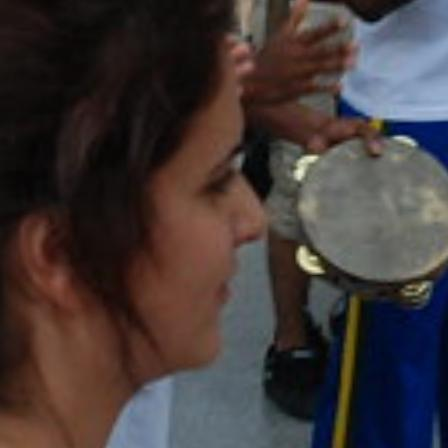

**image_647.jpg**


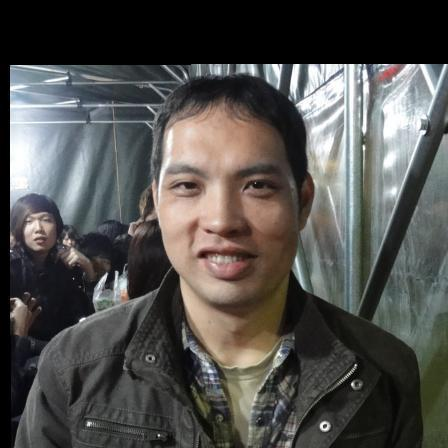

**image_858.jpg**


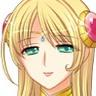

**image_347.jpg**


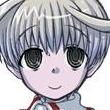

**image_431.jpg**


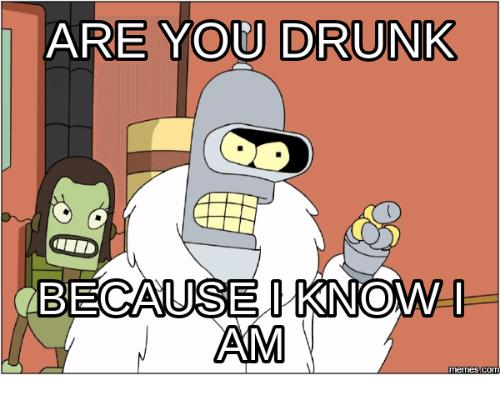

**image_1008.jpg**


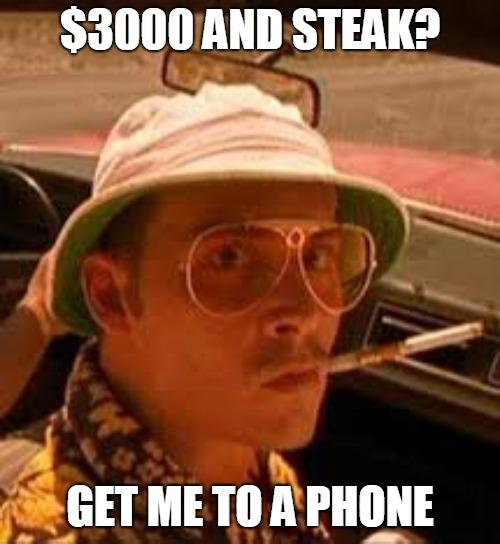

**image_1479.jpg**


In [28]:
# Prepare images and prompt for the model
images_for_model = [img[0] for img in sampled_images]
image_names = [img[1] for img in sampled_images]

# Pass sampled images and the prompt to the model
response = model.generate_content(images_for_model + [prompt])

# Display the conversation with images
output_text = response.text

# Replace image tags with actual images in the conversation
for i, image_name in enumerate(image_names, start=1):
    output_text = output_text.replace(f"<img{i}>", f"![{image_name}](attachment:{image_name})")

# Display the output as Markdown
display(Markdown(output_text))

# Display the images inline
for img, img_name in sampled_images:
    display(img)
    print(f"**{img_name}**")